In [1]:
import os
import sys
import random
from ultralytics import YOLO
from IPython.display import Image

# Add the 'src' directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Now we can import your config file
from config import Config

In [2]:
# --- 1. Define Model Path (robust) ---
model_name = 'best.pt'
candidate_paths = [
    os.path.join('..', 'models', 'weights', model_name),                       # ../models/weights/best.pt
    os.path.join('..', Config.MODEL_PHASE1_WEIGHTS),                           # runs/detect/...
    Config.MODEL_PHASE1_WEIGHTS,                                               # relative runs/...
    str(Config.REPO_ROOT / 'models' / 'weights' / model_name)                  # absolute path variant
]
model_path = next((p for p in candidate_paths if p and os.path.exists(p)), None)

print("Checked model paths:")
for p in candidate_paths:
    print("  ", p, "->", "OK" if os.path.exists(p) else "MISSING")

if not model_path:
    raise FileNotFoundError("Model file not found. Put best.pt in ../models/weights/ or update model_path.")
print("Using model:", model_path)

# --- 2. Define Test Image Path (use Config.IMAGES_DIR which is absolute) ---
images_dir = Config.IMAGES_DIR
if not os.path.isdir(images_dir):
    raise FileNotFoundError(f"Images dir not found: {images_dir}")
test_image_name = random.choice(os.listdir(images_dir))
image_path = os.path.join(images_dir, test_image_name)
print("Using image:", image_path)

Checked model paths:
   ../models/weights/best.pt -> MISSING
   /Users/macm4/repositories/2Phase-Object-Detection/runs/detect/yolov8_phase1_coarse/weights/best.pt -> OK
   /Users/macm4/repositories/2Phase-Object-Detection/runs/detect/yolov8_phase1_coarse/weights/best.pt -> OK
   /Users/macm4/repositories/2Phase-Object-Detection/models/weights/best.pt -> MISSING
Using model: /Users/macm4/repositories/2Phase-Object-Detection/runs/detect/yolov8_phase1_coarse/weights/best.pt
Using image: /Users/macm4/repositories/2Phase-Object-Detection/dataset/colorful_fashion_dataset_for_object_detection/JPEGImages/74409.jpg


Results saved to /Users/macm4/repositories/Machine Learning Model/modisch-model/runs/detect/predict
Detections: 3
Latency (s) mean=0.0061 p50=0.0062 p95=0.0065 | FPS~163.07
 0: bbox=[73.10787963867188, 228.29721069335938, 324.0511779785156, 428.0239562988281], conf=0.933, class=1 (BOTTOM)
 1: bbox=[120.45530700683594, 117.93567657470703, 331.88433837890625, 257.84124755859375], conf=0.819, class=0 (TOP)
 2: bbox=[176.8077392578125, 533.8535766601562, 294.3033447265625, 587.4248046875], conf=0.494, class=2 (SHOES)
Saved latency/FPS metrics to: /Users/macm4/repositories/2Phase-Object-Detection/runs/detect/yolov8_phase1_coarse/latency_fps.json
Annotated image saved to: /Users/macm4/repositories/Machine Learning Model/modisch-model/runs/detect/predict/74409.jpg


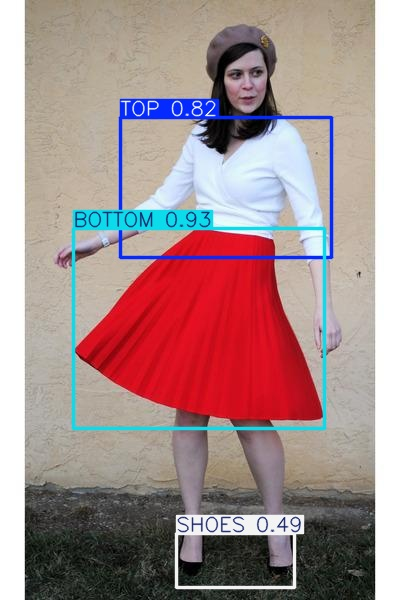

In [3]:
# --- 3. Load model and run prediction with latency/FPS logging ---
import json
import time
from pathlib import Path

import numpy as np

model = YOLO(model_path)

# Inference settings
CONF = 0.2
IOU = 0.45
MAX_DET = 200

def _resolve_training_run_dir(phase_glob: str) -> Path | None:
    matches = sorted(Path('..').glob(phase_glob))
    if matches:
        return matches[-1].resolve()
    return None

# Try to resolve the training run directory to save metrics into
training_run_dir = None
try:
    mp = Path(model_path).expanduser().resolve()
    # weights/best.pt -> weights_dir.parent is the run dir
    if mp.parent.name == 'weights' and mp.exists():
        training_run_dir = mp.parent.parent
except Exception:
    training_run_dir = None

if training_run_dir is None or not training_run_dir.exists():
    training_run_dir = _resolve_training_run_dir('runs/detect/yolov8_phase1_coarse*')

# 1) Warmup (no save)
_ = model.predict(source=image_path, conf=CONF, iou=IOU, max_det=MAX_DET, save=False, verbose=False)

# 2) Timed runs (no save, avoids disk I/O impacting timing)
N_RUNS = 10
times_s: list[float] = []
for _i in range(N_RUNS):
    t0 = time.perf_counter()
    _ = model.predict(source=image_path, conf=CONF, iou=IOU, max_det=MAX_DET, save=False, verbose=False)
    t1 = time.perf_counter()
    times_s.append(t1 - t0)

times_arr = np.array(times_s, dtype=float)
lat_mean = float(times_arr.mean())
lat_p50 = float(np.percentile(times_arr, 50))
lat_p95 = float(np.percentile(times_arr, 95))
fps_mean = float(1.0 / lat_mean) if lat_mean > 0 else float('inf')

# 3) One run with save=True for visualization/output
results = model.predict(source=image_path, conf=CONF, iou=IOU, max_det=MAX_DET, save=True)
res = results[0]

n_boxes = len(res.boxes)
print(f"Detections: {n_boxes}")
print(f"Latency (s) mean={lat_mean:.4f} p50={lat_p50:.4f} p95={lat_p95:.4f} | FPS~{fps_mean:.2f}")
if n_boxes == 0:
    print("No boxes detected — try lowering conf or checking model weights.")
else:
    for i, box in enumerate(res.boxes):
        xyxy = box.xyxy[0].cpu().numpy()
        conf = float(box.conf[0].cpu().numpy()) if hasattr(box, 'conf') else None
        cls_id = int(box.cls[0].cpu().numpy()) if hasattr(box, 'cls') else None
        cls_name = model.names[cls_id] if cls_id is not None and cls_id in model.names else str(cls_id)
        print(f" {i}: bbox={xyxy.tolist()}, conf={conf:.3f}, class={cls_id} ({cls_name})")

# Save latency/FPS metrics inside the training run folder (runs/detect/...)
metrics = {
    "phase": "phase1",
    "image": str(image_path),
    "conf": CONF,
    "iou": IOU,
    "max_det": MAX_DET,
    "n_runs": N_RUNS,
    "latency_seconds": {
        "mean": lat_mean,
        "p50": lat_p50,
        "p95": lat_p95,
        "min": float(times_arr.min()),
        "max": float(times_arr.max()),
    },
    "fps": {"mean": fps_mean},
    "detections": int(n_boxes),
}
if training_run_dir is not None:
    try:
        training_run_dir.mkdir(parents=True, exist_ok=True)
        metrics_path = training_run_dir / 'latency_fps.json'
        metrics_path.write_text(json.dumps(metrics, indent=2), encoding='utf-8')
        print("Saved latency/FPS metrics to:", str(metrics_path))
    except Exception as e:
        print("⚠️ Failed to write latency/FPS metrics:", e)
else:
    print("⚠️ Training run dir not found; metrics not written.")

# Show annotated image produced by YOLO
annotated_dir = res.save_dir
annotated_path = os.path.join(annotated_dir, test_image_name)
print("Annotated image saved to:", annotated_path)

from IPython.display import Image, display
display(Image(filename=annotated_path))

In [4]:

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from glob import glob


Visualizing results from: ../runs/detect/yolov8_phase1_coarse


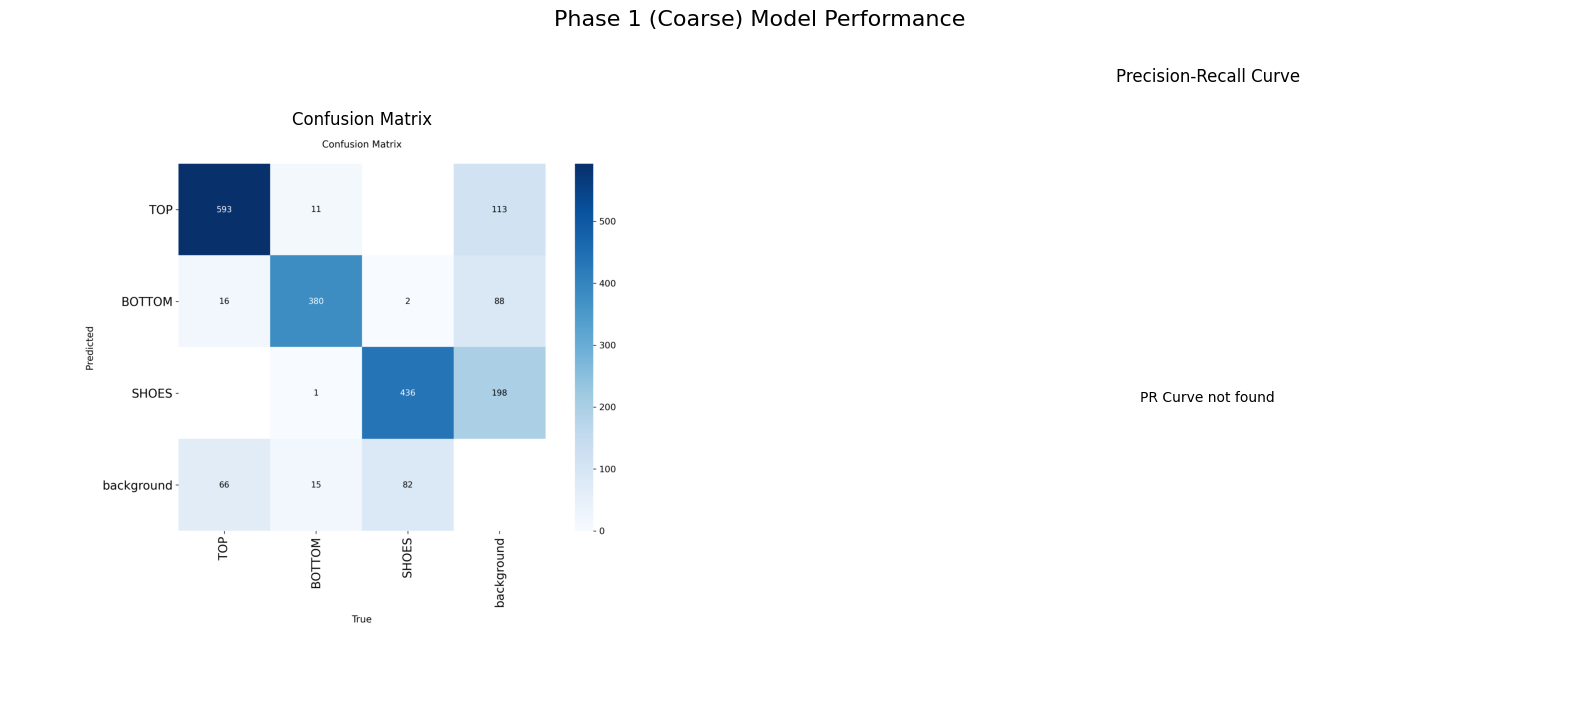

In [5]:
# --- 📊 Visualize Phase 1 Results ---
phase1_run_dir = sorted(glob(os.path.join('..', 'runs', 'detect', 'yolov8_phase1_coarse*')))[-1]
print(f"Visualizing results from: {phase1_run_dir}")

# Display Confusion Matrix and PR Curve
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Phase 1 (Coarse) Model Performance', fontsize=16)

# Confusion Matrix
cm_path = os.path.join(phase1_run_dir, 'confusion_matrix.png')
if os.path.exists(cm_path):
    cm_img = cv2.imread(cm_path)
    if cm_img is not None:
        axes[0].imshow(cv2.cvtColor(cm_img, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Confusion Matrix')
        axes[0].axis('off')
    else:
        axes[0].text(0.5, 0.5, 'Failed to load image', ha='center', va='center')
        axes[0].set_title('Confusion Matrix')
        axes[0].axis('off')
else:
    axes[0].text(0.5, 0.5, 'Confusion Matrix not found', ha='center', va='center')
    axes[0].set_title('Confusion Matrix')
    axes[0].axis('off')

# PR Curve
pr_path = os.path.join(phase1_run_dir, 'PR_curve.png')
if os.path.exists(pr_path):
    pr_img = cv2.imread(pr_path)
    if pr_img is not None:
        axes[1].imshow(cv2.cvtColor(pr_img, cv2.COLOR_BGR2RGB))
        axes[1].set_title('Precision-Recall Curve')
        axes[1].axis('off')
    else:
        axes[1].text(0.5, 0.5, 'Failed to load image', ha='center', va='center')
        axes[1].set_title('Precision-Recall Curve')
        axes[1].axis('off')
else:
    axes[1].text(0.5, 0.5, 'PR Curve not found', ha='center', va='center')
    axes[1].set_title('Precision-Recall Curve')
    axes[1].axis('off')